In [3]:
from pathlib import Path
from urllib.parse import urlparse
import requests, json
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib import patches

In [45]:
subscriptionkey = '78ccc6fc-0ece-4e57-b9e5-87989bee3'
key = '0c928b0b6f6644bba4e94ba1461bd'
# https://nik-faceapi-1.cognitiveservices.azure.com/
face_api_url = 'https://nik-faceapi-1.cognitiveservices.azure.com/face/v1.0/detect'

In [42]:
def inference_image(image_url, subs_key, api_key, show_face_id=False):
    header = {'OCP-Apim-Subscription-Key': subs_key}

    params = {
        'returnFaceId': 'true',
        'returnFaceLandmarks':'false',
        'returnFaceAttributes': 'age, gender'
    }

    parsed_url = urlparse(image_url)
    if parsed_url.scheme == 'file':
        image_data = open(parsed_url.path, 'rb').read()
        header['Content-Type'] = 'application/octet-stream'
        response = requests.post(api_key, params=params, headers=header, data=image_data)
        image = Image.open(parsed_url.path)
    else:
        response = requests.post(api_key, params=params, headers=header, json={"url": image_url})
        image_file = BytesIO(requests.get(image_url).content)
        image = Image.open(image_file)
    
    faces = response.json()
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image) #, alpha=6)
    print(faces)
    for face in faces:
        fr = face["faceRectangle"]
        fa = face["faceAttributes"]
        origin = (fr['left'], fr["top"])
        p = patches.Rectangle(origin, fr["width"], fr["height"], fill=False, linewidth=2, color='b')
        ax.axes.add_patch(p)
        ax.text(origin[0], origin[1], "%s, %d"%(fa["gender"].apitalize(), fa["age"]), fontsize=16, weight="bold", va= "bottom")
        if show_face_id:
            ax.text(origin[0], origin[1]+fr["height"], "%s"%(face["faceId"][:5]), fontsize=12, va="bottom")
    ax.axis("off")
    plt.close()
    return fig, faces


{'error': {'code': 'InvalidRequest', 'message': 'Invalid request has been sent.', 'innererror': {'code': 'UnsupportedFeature', 'message': 'Feature is not supported, missing approval for one or more of the following features: Identification,Verification. Please apply for access at https://aka.ms/facerecognition'}}}


TypeError: string indices must be integers

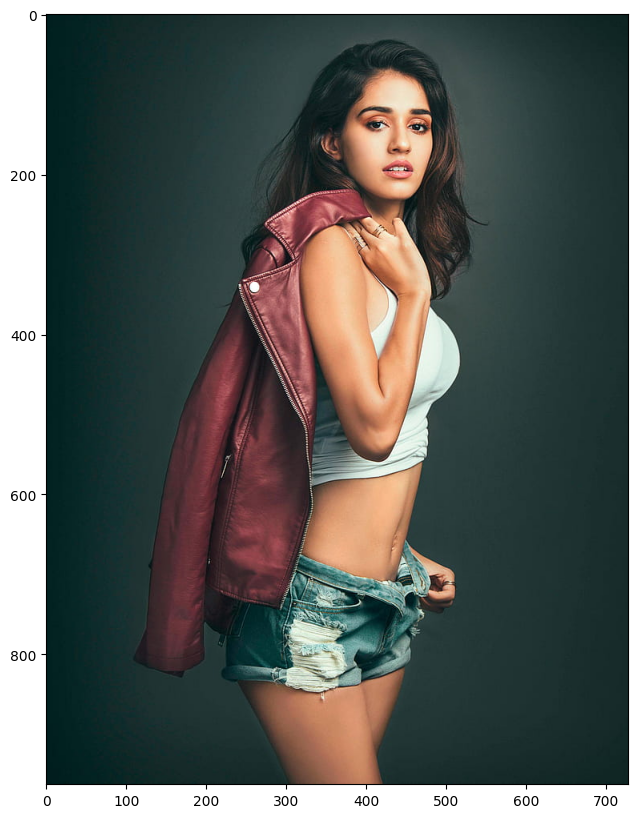

In [43]:
image_url = 'https://c4.wallpaperflare.com/wallpaper/598/699/634/disha-patani-women-actress-model-bollywood-actresses-hd-wallpaper-preview.jpg'
# 'https://c4.wallpaperflare.com/wallpaper/358/338/510/tianna-gregory-women-model-brunette-wallpaper-preview.jpg'
# 'shiva-hardy-2.png'
# 'https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.shutterstock.com%2Fshutterstock%2Fphotos%2F2116991546%2Fdisplay_1500%2Fstock-photo-multi-ethnic-guys-and-girls-taking-selfie-outdoors-with-backlight-happy-life-style-friendship-2116991546.jpg&tbnid=FRea-S3aJW2GWM&vet=12ahUKEwjb2YLG75qCAxXXZmwGHaVlDncQMygAegQIARBu..i&imgrefurl=https%3A%2F%2Fwww.shutterstock.com%2Fsearch%2Fgroup&docid=Hj8R3T_U4TjQDM&w=1500&h=1101&q=group%20image&ved=2ahUKEwjb2YLG75qCAxXXZmwGHaVlDncQMygAegQIARBu'
labeled_image, responce_1 = inference_image(image_url, key, face_api_url, show_face_id=True)
# labeled_image

In [46]:
import json, os, requests
subscription_key = key
# face_api_url = face_api_url + '/face/v1.0/detect'
image_url = 'https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/faces.jpg'
headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {
    'detectionModel': 'detection_03',
    'returnFaceId': 'true'
}
response = requests.post(face_api_url, params=params,
                         headers=headers, json={"url": image_url})
print(json.dumps(response.json()))

{"error": {"code": "InvalidRequest", "message": "Invalid request has been sent.", "innererror": {"code": "UnsupportedFeature", "message": "Feature is not supported, missing approval for one or more of the following features: Identification,Verification. Please apply for access at https://aka.ms/facerecognition"}}}


In [40]:
import asyncio
import io
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
# To install this module, run:
# python -m pip install Pillow
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person, QualityForRecognition

# This key will serve all examples in this document.
# KEY = os.environ["VISION_KEY"]

KEY = '73f0e2f06c354033b2c51f246ea0f'
# This endpoint will be used in all examples in this quickstart.
# ENDPOINT = os.environ["VISION_ENDPOINT"] 
ENDPOINT = 'https://nik-faceapi-1.cognitiveservices.azure.com/'
# Base url for the Verify and Facelist/Large Facelist operations
IMAGE_BASE_URL = 'https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/'

# Used in the Person Group Operations and Delete Person Group examples.
# You can call list_person_groups to print a list of preexisting PersonGroups.
# SOURCE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)
# Used for the Delete Person Group example.
TARGET_PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

'''
Create the PersonGroup
'''
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID, recognition_model='recognition_04')

# Define woman friend
woman = face_client.person_group_person.create(PERSON_GROUP_ID, name="Woman")
# Define man friend
man = face_client.person_group_person.create(PERSON_GROUP_ID, name="Man")
# Define child friend
child = face_client.person_group_person.create(PERSON_GROUP_ID, name="Child")

'''
Detect faces and register them to each person
'''
# Find all jpeg images of friends in working directory (TBD pull from web instead)
woman_images = ["https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/Family1-Mom1.jpg", "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/Family1-Mom2.jpg"]
man_images = ["https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/Family1-Dad1.jpg", "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/Family1-Dad2.jpg"]
child_images = ["https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/Family1-Son1.jpg", "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/Family1-Son2.jpg"]

# Add to woman person
for image in woman_images:
    # Check if the image is of sufficent quality for recognition.
    sufficientQuality = True
    detected_faces = face_client.face.detect_with_url(url=image, detection_model='detection_03', recognition_model='recognition_04', return_face_attributes=['qualityForRecognition'])
    for face in detected_faces:
        if face.face_attributes.quality_for_recognition != QualityForRecognition.high:
            sufficientQuality = False
            break
        face_client.person_group_person.add_face_from_url(PERSON_GROUP_ID, woman.person_id, image)
        print("face {} added to person {}".format(face.face_id, woman.person_id))

    if not sufficientQuality: continue

# Add to man person
for image in man_images:
    # Check if the image is of sufficent quality for recognition.
    sufficientQuality = True
    detected_faces = face_client.face.detect_with_url(url=image, detection_model='detection_03', recognition_model='recognition_04', return_face_attributes=['qualityForRecognition'])
    for face in detected_faces:
        if face.face_attributes.quality_for_recognition != QualityForRecognition.high:
            sufficientQuality = False
            break
        face_client.person_group_person.add_face_from_url(PERSON_GROUP_ID, man.person_id, image)
        print("face {} added to person {}".format(face.face_id, man.person_id))

    if not sufficientQuality: continue

# Add to child person
for image in child_images:
    # Check if the image is of sufficent quality for recognition.
    sufficientQuality = True
    detected_faces = face_client.face.detect_with_url(url=image, detection_model='detection_03', recognition_model='recognition_04', return_face_attributes=['qualityForRecognition'])
    for face in detected_faces:
        if face.face_attributes.quality_for_recognition != QualityForRecognition.high:
            sufficientQuality = False
            print("{} has insufficient quality".format(face))
            break
        face_client.person_group_person.add_face_from_url(PERSON_GROUP_ID, child.person_id, image)
        print("face {} added to person {}".format(face.face_id, child.person_id))
    if not sufficientQuality: continue


'''
Train PersonGroup
'''
# Train the person group
print("pg resource is {}".format(PERSON_GROUP_ID))
rawresponse = face_client.person_group.train(PERSON_GROUP_ID, raw= True)
print(rawresponse)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        face_client.person_group.delete(person_group_id=PERSON_GROUP_ID)
        sys.exit('Training the person group has failed.')
    time.sleep(5)

'''
Identify a face against a defined PersonGroup
'''
# Group image for testing against
test_image = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/Face/images/identification1.jpg"

print('Pausing for 10 seconds to avoid triggering rate limit on free account...')
time.sleep (10)

# Detect faces
face_ids = []
# We use detection model 3 to get better performance, recognition model 4 to support quality for recognition attribute.
faces = face_client.face.detect_with_url(test_image, detection_model='detection_03', recognition_model='recognition_04', return_face_attributes=['qualityForRecognition'])
for face in faces:
    # Only take the face if it is of sufficient quality.
    if face.face_attributes.quality_for_recognition == QualityForRecognition.high or face.face_attributes.quality_for_recognition == QualityForRecognition.medium:
        face_ids.append(face.face_id)

# Identify faces
results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
print('Identifying faces in image')
if not results:
    print('No person identified in the person group')
for identifiedFace in results:
    if len(identifiedFace.candidates) > 0:
        print('Person is identified for face ID {} in image, with a confidence of {}.'.format(identifiedFace.face_id, identifiedFace.candidates[0].confidence)) # Get topmost confidence score

        # Verify faces
        verify_result = face_client.face.verify_face_to_person(identifiedFace.face_id, identifiedFace.candidates[0].person_id, PERSON_GROUP_ID)
        print('verification result: {}. confidence: {}'.format(verify_result.is_identical, verify_result.confidence))
    else:
        print('No person identified for face ID {} in image.'.format(identifiedFace.face_id))
 

print()
print('End of quickstart.')

Person group: e893ccb9-7a20-44d1-9ec9-5ea9d9c3cc13


APIErrorException: (InvalidRequest) Invalid request has been sent.